In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

In [3]:
#os.chdir('../..')

In [4]:
# sys.path

# in order to import custom modules (e.g. ukbRequestHelpers)

# targetdir = os.path.dirname(os.getcwd())
# sys.path.insert(0,os.path.join(targetdir))
# sys.path.insert(0,os.path.join(targetdir, 'deepadr'))

In [5]:
# !/opt/conda/bin/pip install --prefix $HOME/custom_packages/ -e ~/chemprop_run/git/

In [6]:
# help('modules')

In [7]:
import torch
from torch_geometric.data import Data

In [8]:
cwd = os.getcwd()
print(cwd)

/cluster/home/skyriakos/chemprop_run/git/notebooks


In [9]:
#!ls data

In [10]:
os.chdir('..')
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
os.chdir(cwd)

In [11]:
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

In [12]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [13]:
# from tdc.single_pred import Tox
from tdc.multi_pred import DDI

In [14]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [15]:
report_available_cuda_devices()

number of GPUs available: 1
cuda:0, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB



In [16]:
n_gpu = torch.cuda.device_count()
n_gpu

1

### Preparing dataset 

In [17]:
# TDC Tox
DSdataset_name = 'DrugBank'

#fname_suffix = ds_config["fname_suffix"]
similarity_types = ['chem']
kernel_option = 'sqeuclidean'
data_fname = 'data_v1'
# interact_matfname = ds_config["interact_matfname"]
# exp_iden = 'simtypeall'
# ddi_interaction_labels_pth = ds_config["ddi_interaction_labels_pth"]

# up_dir, processed_dir, DSdataset_name, data_fname

In [18]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
# ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))

path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr


In [19]:
data = DDI(name = DSdataset_name).get_data(format = 'df')

Found local copy...
Loading...
Done!


In [20]:
# from tdc.utils import get_label_map
# get_label_map(name = 'DrugBank', task = 'DDI')


In [21]:
# data = Tox(name = DSdataset_name).get_data(format = 'df')
# smiles, labels = data['Drug'], data['Y']

In [22]:
data

,Drug1_ID,Drug1,Drug2_ID,Drug2,Y
0,DB04571,CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
1,DB00855,NCC(=O)CCC(O)=O,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
2,DB09536,O=[Ti]=O,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
3,DB01600,CC(C(O)=O)C1=CC=C(S1)C(=O)C1=CC=CC=C1,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
4,DB09000,CC(CN(C)C)CN1C2=CC=CC=C2SC2=C1C=C(C=C2)C#N,DB00460,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C...,1
...,...,...,...,...,...
191803,DB00437,OC1=NC=NC2=C1C=NN2,DB00492,CCC(=O)O[C@@H](O[P@](=O)(CCCCC1=CC=CC=C1)CC(=O...,86
191804,DB00437,OC1=NC=NC2=C1C=NN2,DB09477,[H][C@@](C)(N[C@@]([H])(CCC1=CC=CC=C1)C(O)=O)C...,86
191805,DB00437,OC1=NC=NC2=C1C=NN2,DB00790,[H][C@]12C[C@H](N(C(=O)[C@H](C)N[C@@H](CCC)C(=...,86
191806,DB00415,[H][C@]12SC(C)(C)[C@@H](N1C(=O)[C@H]2NC(=O)[C@...,DB00437,OC1=NC=NC2=C1C=NN2,86


In [23]:
uniq_data = ddi_dataframe_to_unique_drugs(data)
uniq_data

,Drug_ID,Drug
0,DB04571,CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1
1,DB00855,NCC(=O)CCC(O)=O
2,DB09536,O=[Ti]=O
3,DB01600,CC(C(O)=O)C1=CC=C(S1)C(=O)C1=CC=CC=C1
4,DB09000,CC(CN(C)C)CN1C2=CC=CC=C2SC2=C1C=C(C=C2)C#N
...,...,...
1701,DB11121,CC1=CC(O)=CC(C)=C1Cl
1702,DB00711,CCN(CC)C(=O)N1CCN(C)CC1
1703,DB09061,CCCCCC1=CC(O)=C([C@@H]2C=C(C)CC[C@H]2C(C)=C)C(...
1704,DB00198,CCOC(=O)C1=C[C@@H](OC(CC)CC)[C@H](NC(C)=O)[C@@...


In [24]:
uniq_data['Mol'] = [smiles_to_mol(smiles) for smiles in uniq_data.Drug]

In [25]:
uniq_mol = uniq_data[~uniq_data.Mol.isnull()]
uniq_mol['Data'] = [mol_to_graph_data_obj_simple(mol) for mol in uniq_mol.Mol]
uniq_mol

,Drug_ID,Drug,Mol,Data
0,DB04571,CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1,<rdkit.Chem.rdchem.Mol object at 0x2ab9ab8d7800>,"[(edge_attr, [tensor([0, 0]), tensor([0, 0]), ..."
1,DB00855,NCC(=O)CCC(O)=O,<rdkit.Chem.rdchem.Mol object at 0x2ab9ab8d7710>,"[(edge_attr, [tensor([0, 0]), tensor([0, 0]), ..."
2,DB09536,O=[Ti]=O,<rdkit.Chem.rdchem.Mol object at 0x2ab9ab8d79e0>,"[(edge_attr, [tensor([1, 0]), tensor([1, 0]), ..."
3,DB01600,CC(C(O)=O)C1=CC=C(S1)C(=O)C1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x2ab9ab8d78f0>,"[(edge_attr, [tensor([0, 0]), tensor([0, 0]), ..."
4,DB09000,CC(CN(C)C)CN1C2=CC=CC=C2SC2=C1C=C(C=C2)C#N,<rdkit.Chem.rdchem.Mol object at 0x2ab9ab8d7ad0>,"[(edge_attr, [tensor([0, 0]), tensor([0, 0]), ..."
...,...,...,...,...
1701,DB11121,CC1=CC(O)=CC(C)=C1Cl,<rdkit.Chem.rdchem.Mol object at 0x2ab9ac81fda0>,"[(edge_attr, [tensor([0, 0]), tensor([0, 0]), ..."
1702,DB00711,CCN(CC)C(=O)N1CCN(C)CC1,<rdkit.Chem.rdchem.Mol object at 0x2ab9ac81fdf0>,"[(edge_attr, [tensor([0, 0]), tensor([0, 0]), ..."
1703,DB09061,CCCCCC1=CC(O)=C([C@@H]2C=C(C)CC[C@H]2C(C)=C)C(...,<rdkit.Chem.rdchem.Mol object at 0x2ab9ac81fe40>,"[(edge_attr, [tensor([0, 0]), tensor([0, 0]), ..."
1704,DB00198,CCOC(=O)C1=C[C@@H](OC(CC)CC)[C@H](NC(C)=O)[C@@...,<rdkit.Chem.rdchem.Mol object at 0x2ab9ac81fe90>,"[(edge_attr, [tensor([0, 0]), tensor([0, 0]), ..."


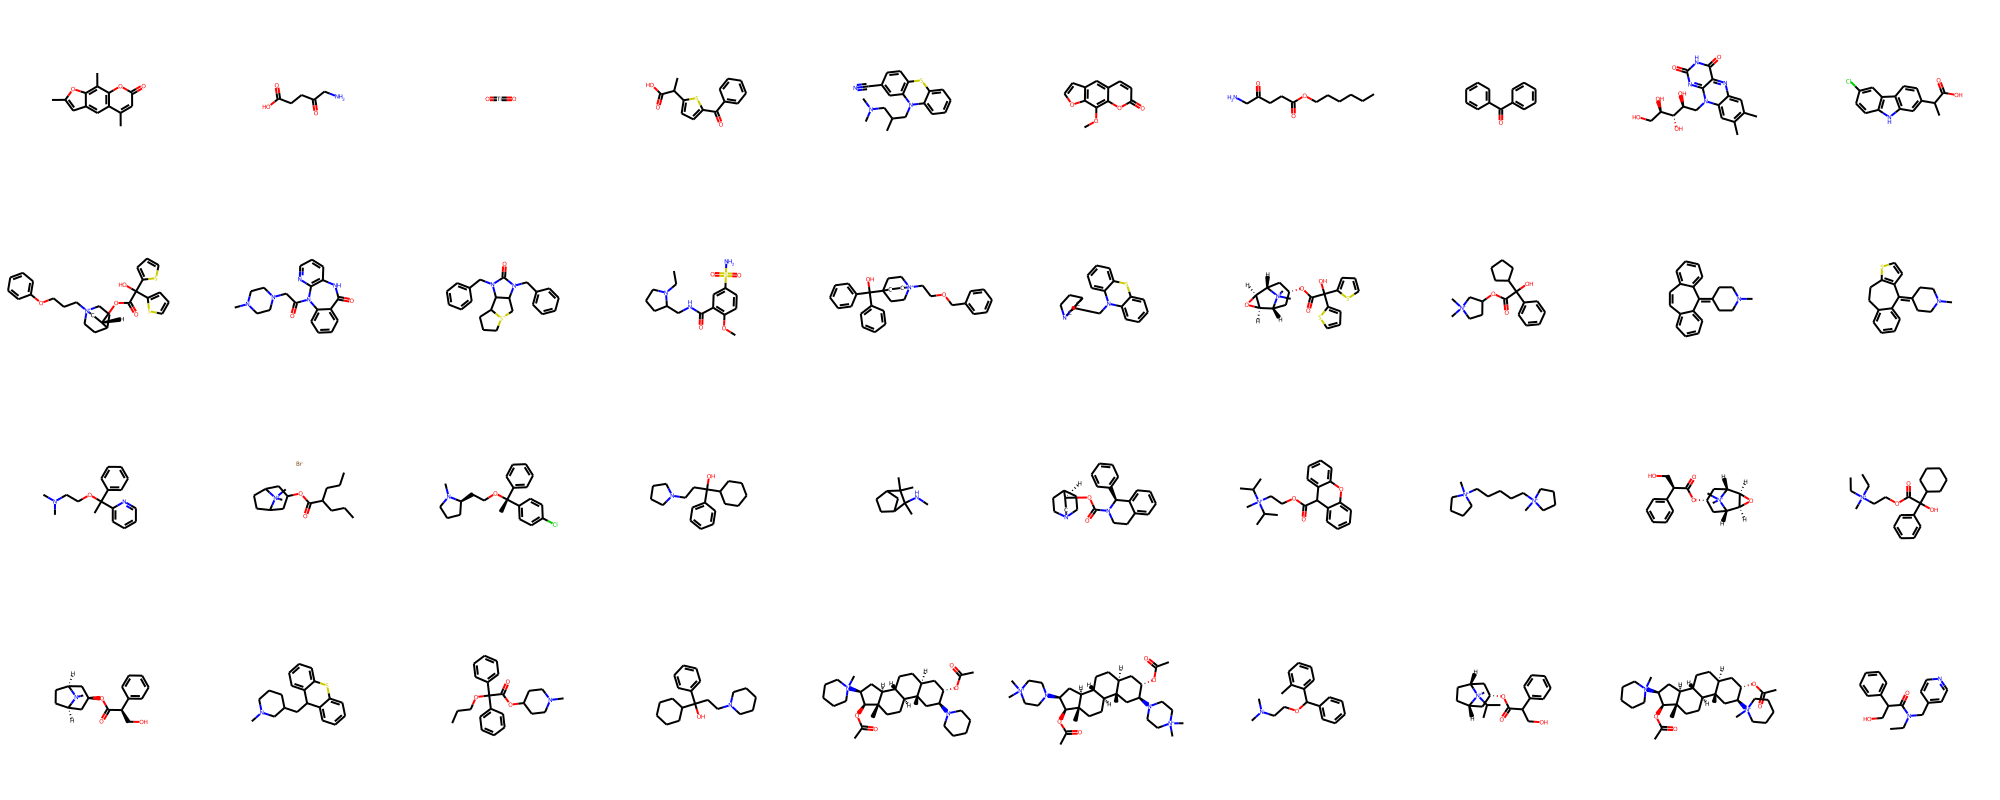

In [26]:
Draw.MolsToGridImage(uniq_mol.Mol.head(40), molsPerRow=10)

In [27]:
num_drugs = len(uniq_mol)
(num_drugs * (num_drugs-1))/2

1445850.0

In [28]:
# y_df = generate_labels_df(uniq_mol, data)

# ReaderWriter.dump_data(y_df, os.path.join(targetdata_dir_raw, 'y_df.pkl'))

y_df = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y_df.pkl'))

In [29]:
y_df

Drug_ID,DB04571,DB00855,DB09536,DB01600,DB09000,DB00553,DB06261,DB01878,DB00140,DB00821,...,DB05630,DB04967,DB08974,DB06816,DB11254,DB11121,DB00711,DB09061,DB00198,DB01284
Drug_ID,,,,,,,,,,,,,,,,,,,,,
DB04571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB09536,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB01600,0,0,0,0,0,0,0,0,0,49,...,0,0,0,0,0,0,0,0,0,0
DB09000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB11121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB09061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
y_df[y_df > 0] = 1
y_df

Drug_ID,DB04571,DB00855,DB09536,DB01600,DB09000,DB00553,DB06261,DB01878,DB00140,DB00821,...,DB05630,DB04967,DB08974,DB06816,DB11254,DB11121,DB00711,DB09061,DB00198,DB01284
Drug_ID,,,,,,,,,,,,,,,,,,,,,
DB04571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB09536,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB01600,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
DB09000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB11121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB09061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
y = get_y_from_interactionmat(y_df.to_numpy())
len(y)

1445850

In [32]:
ReaderWriter.dump_data(y, os.path.join(targetdata_dir_raw, 'y.pkl'))
y

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
report_label_distrib(y)

class: 0 norm count: 0.8677380087837604
class: 1 norm count: 0.13226199121623958


In [34]:
# pairs = list(itertools.combinations(uniq_mol.Drug_ID, 2))
pairs = construct_sampleid_ddipairs(y_df.to_numpy())
len(pairs)

1445850

In [35]:
pairs

{0: (0, 1),
 1: (0, 2),
 2: (0, 3),
 3: (0, 4),
 4: (0, 5),
 5: (0, 6),
 6: (0, 7),
 7: (0, 8),
 8: (0, 9),
 9: (0, 10),
 10: (0, 11),
 11: (0, 12),
 12: (0, 13),
 13: (0, 14),
 14: (0, 15),
 15: (0, 16),
 16: (0, 17),
 17: (0, 18),
 18: (0, 19),
 19: (0, 20),
 20: (0, 21),
 21: (0, 22),
 22: (0, 23),
 23: (0, 24),
 24: (0, 25),
 25: (0, 26),
 26: (0, 27),
 27: (0, 28),
 28: (0, 29),
 29: (0, 30),
 30: (0, 31),
 31: (0, 32),
 32: (0, 33),
 33: (0, 34),
 34: (0, 35),
 35: (0, 36),
 36: (0, 37),
 37: (0, 38),
 38: (0, 39),
 39: (0, 40),
 40: (0, 41),
 41: (0, 42),
 42: (0, 43),
 43: (0, 44),
 44: (0, 45),
 45: (0, 46),
 46: (0, 47),
 47: (0, 48),
 48: (0, 49),
 49: (0, 50),
 50: (0, 51),
 51: (0, 52),
 52: (0, 53),
 53: (0, 54),
 54: (0, 55),
 55: (0, 56),
 56: (0, 57),
 57: (0, 58),
 58: (0, 59),
 59: (0, 60),
 60: (0, 61),
 61: (0, 62),
 62: (0, 63),
 63: (0, 64),
 64: (0, 65),
 65: (0, 66),
 66: (0, 67),
 67: (0, 68),
 68: (0, 69),
 69: (0, 70),
 70: (0, 71),
 71: (0, 72),
 72: (0, 73

In [36]:
# pairs_sub = {k: pairs[k] for k in range(10)}
# pairs_sub

In [37]:
# X = get_X_all_pairdata(uniq_mol, pairs)

# ReaderWriter.dump_data(X, os.path.join(targetdata_dir_raw, 'X.pkl'))

X = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'X.pkl'))


In [38]:
X

{0: PairData(edge_attr_a=[38, 2], edge_attr_b=[16, 2], edge_index_a=[2, 38], edge_index_b=[2, 16], x_a=[17, 2], x_b=[9, 2]),
 1: PairData(edge_attr_a=[38, 2], edge_attr_b=[4, 2], edge_index_a=[2, 38], edge_index_b=[2, 4], x_a=[17, 2], x_b=[3, 2]),
 2: PairData(edge_attr_a=[38, 2], edge_attr_b=[38, 2], edge_index_a=[2, 38], edge_index_b=[2, 38], x_a=[17, 2], x_b=[18, 2]),
 3: PairData(edge_attr_a=[38, 2], edge_attr_b=[50, 2], edge_index_a=[2, 38], edge_index_b=[2, 50], x_a=[17, 2], x_b=[23, 2]),
 4: PairData(edge_attr_a=[38, 2], edge_attr_b=[36, 2], edge_index_a=[2, 38], edge_index_b=[2, 36], x_a=[17, 2], x_b=[16, 2]),
 5: PairData(edge_attr_a=[38, 2], edge_attr_b=[28, 2], edge_index_a=[2, 38], edge_index_b=[2, 28], x_a=[17, 2], x_b=[15, 2]),
 6: PairData(edge_attr_a=[38, 2], edge_attr_b=[30, 2], edge_index_a=[2, 38], edge_index_b=[2, 30], x_a=[17, 2], x_b=[14, 2]),
 7: PairData(edge_attr_a=[38, 2], edge_attr_b=[58, 2], edge_index_a=[2, 38], edge_index_b=[2, 58], x_a=[17, 2], x_b=[27, 2

In [39]:
dataset = MoleculeDataset(root=targetdata_dir)

Processing...
exit process(self)
Done!


### Generate datapartitions (i.e. train/val, test indices)

In [39]:
dpartitions = get_stratified_partitions(y, num_folds=5, valid_set_portion=0.1, random_state=42)

fold_num: 0
train data
class: 0 norm count: 0.8677383161769509
class: 1 norm count: 0.13226168382304912
validation data
class: 0 norm count: 0.8677335131583498
class: 1 norm count: 0.13226648684165024
test data
class: 0 norm count: 0.867738700418439
class: 1 norm count: 0.13226129958156102

-------------------------
fold_num: 1
train data
class: 0 norm count: 0.8677383161769509
class: 1 norm count: 0.13226168382304912
validation data
class: 0 norm count: 0.8677335131583498
class: 1 norm count: 0.13226648684165024
test data
class: 0 norm count: 0.867738700418439
class: 1 norm count: 0.13226129958156102

-------------------------
fold_num: 2
train data
class: 0 norm count: 0.8677383161769509
class: 1 norm count: 0.13226168382304912
validation data
class: 0 norm count: 0.8677335131583498
class: 1 norm count: 0.13226648684165024
test data
class: 0 norm count: 0.867738700418439
class: 1 norm count: 0.13226129958156102

-------------------------
fold_num: 3
train data
class: 0 norm count: 0.

In [40]:
# dump data on disk
# targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))

### Create Tensors

In [40]:
device_cpu = get_device(to_gpu=False)
device_gpu = get_device(True, index=0)

### Using masking and inference with gip computation

In [56]:
gip_perfold = {}
for fold_id in dpartitions:
    masked_intermat = interaction_mat.copy()
    masked_intermat = masked_intermat.astype(np.float)
    for dsettype in ('validation', 'test'):
        # get validation/test ddi pair indices
        sids = dpartitions[fold_id][dsettype]
        a = [sid_ddipairs_map[sid][0] for sid in sids]
        b = [sid_ddipairs_map[sid][1] for sid in sids]
        # set to nan
        masked_intermat[tuple([a,b])] = np.nan
        masked_intermat[tuple([b,a])] = np.nan
        
    intermat_infer_lst = []
    nanw_mat_lst = []
    for similarity_type in similarity_types:
        print('similarity_type', similarity_type)
        siminput_feat_pth = os.path.join(up_dir, rawdata_dir, DSdataset_name, '{}{}'.format(similarity_type, fname_suffix))
        sim_mat = get_similarity_matrix(siminput_feat_pth, DSdataset_name)
        imat_infer, nanw_m = impute_nan(masked_intermat, sim_mat, k=15)
        intermat_infer_lst.append(imat_infer)
        nanw_mat_lst.append(nanw_m)
        
    infer_mat_fus = weight_inferred_mat(nanw_mat_lst, intermat_infer_lst)

    print('norm(infer_mat-interaction_mat)', np.linalg.norm(infer_mat_fus - interaction_mat))

    # compute GIP here
    gip_kernel = compute_gip_kernel(infer_mat_fus, 1., kernel_option)
    print('norm(gip_kernel-interaction_mat)',np.linalg.norm(gip_kernel - interaction_mat))
    t = gip_kernel-interaction_mat
    print(np.sum(np.abs(t) > 0.5)/(t.size - t.shape[0]))
    gip_perfold[fold_id] = gip_kernel

similarity_type enzyme
similarity_type indication
similarity_type offsideeffect
similarity_type pathway
similarity_type sideeffect
similarity_type target
similarity_type transporter
similarity_type chem
norm(infer_mat-interaction_mat) 95.85996802784743
nan 0
norm(gip_kernel-interaction_mat) 312.59558538149577
0.32598513457612194
similarity_type enzyme
similarity_type indication
similarity_type offsideeffect
similarity_type pathway
similarity_type sideeffect
similarity_type target
similarity_type transporter
similarity_type chem
norm(infer_mat-interaction_mat) 95.91048645102023
nan 0
norm(gip_kernel-interaction_mat) 312.59558538149577
0.32598513457612194
similarity_type enzyme
similarity_type indication
similarity_type offsideeffect
similarity_type pathway
similarity_type sideeffect
similarity_type target
similarity_type transporter
similarity_type chem
norm(infer_mat-interaction_mat) 95.75408444617713
nan 0
norm(gip_kernel-interaction_mat) 312.59558538149577
0.32598513457612194
similar

### Compute features from similarity matrices

#### check if similarity matrix is symmetric

In [57]:
num_sim_types = len(similarity_types)
for similarity_type in similarity_types:
    siminput_feat_pth = os.path.join(up_dir, rawdata_dir, DSdataset_name, '{}{}'.format(similarity_type, fname_suffix))
    sim_mat = get_similarity_matrix(siminput_feat_pth, DSdataset_name)   
    print(np.allclose(sim_mat, np.transpose(sim_mat)))

True
True
True
True
True
True
True
True


In [58]:
num_sim_types = len(similarity_types)
X_feats = []
for similarity_type in similarity_types:
    siminput_feat_pth = os.path.join(up_dir, rawdata_dir, DSdataset_name, '{}{}'.format(similarity_type, fname_suffix))
    X_feat = preprocess_features(siminput_feat_pth, DSdataset_name, fill_diag=None)   
    X_feats.append(X_feat)
X_feat_cat = np.concatenate(X_feats, axis=1)
print("X_feat_cat", X_feat_cat.shape)

X_feat_cat (149878, 8784)


In [59]:
X = create_setvector_features(X_feat_cat, 2*num_sim_types)
X.shape

(149878, 16, 549)

In [60]:
X_a = X[:,list(range(0,2*num_sim_types,2))].copy()
X_b = X[:,list(range(1,2*num_sim_types,2))].copy()

In [61]:
from ddi.utilities import format_bytes
print(format_bytes(X_feat_cat.size * X_feat_cat.itemsize))
print(format_bytes(y.size * y.itemsize))

(4.9, 'gigabytes')
(585.46, 'kilobytes')


In [62]:
# clear unused objects
del X_feats
del X_feat_cat
del X_feat

In [63]:
device_cpu = get_device(to_gpu=False)
device_gpu = get_device(True, index=0)

In [64]:
# dtype is float32 since we will use sigmoid (binary outcome)
y_tensor = torch.tensor(y, dtype = torch.int64, device = device_cpu) 
X_a = torch.tensor(X_a, dtype = torch.float32, device = device_cpu)
X_b = torch.tensor(X_b, dtype = torch.float32, device = device_cpu)
ddi_datatensor = DDIDataTensor(X_a, X_b, y_tensor)

In [65]:
targetdata_dir

'../../data/processed/DS1/data_v1/simtypeall'

In [66]:
# dump data on disk
ReaderWriter.dump_tensor(X_a, os.path.join(targetdata_dir, 'X_a.torch'))
ReaderWriter.dump_tensor(X_b, os.path.join(targetdata_dir, 'X_b.torch'))
ReaderWriter.dump_tensor(y_tensor, os.path.join(targetdata_dir, 'y_tensor.torch'))

### Construct GIP datatensor for each fold

In [67]:
gip_dtensor_perfold = {}
for fold_id in gip_perfold:
    print('fold_id:', fold_id)
    gip_mat = gip_perfold[fold_id]
    print('gip_mat:', gip_mat.shape)
    gip_feat = get_features_from_simmatrix(gip_mat)
    gip_all = create_setvector_features(gip_feat, 2)
    print('gip_all:', gip_all.shape)
    X_a_gip = gip_all[:,list(range(0,2*1,2))].copy()
    X_b_gip = gip_all[:,list(range(1,2*1,2))].copy()
    print('X_a_gip:', X_a_gip.shape)
    X_a_gip = torch.tensor(X_a_gip, dtype = torch.float32, device = device_cpu)
    X_b_gip = torch.tensor(X_b_gip, dtype = torch.float32, device = device_cpu)
    gip_datatensor = GIPDataTensor(X_a_gip, X_b_gip)
    gip_dtensor_perfold[fold_id] = gip_datatensor

fold_id: 0
gip_mat: (548, 548)
gip_all: (149878, 2, 549)
X_a_gip: (149878, 1, 549)
fold_id: 1
gip_mat: (548, 548)
gip_all: (149878, 2, 549)
X_a_gip: (149878, 1, 549)
fold_id: 2
gip_mat: (548, 548)
gip_all: (149878, 2, 549)
X_a_gip: (149878, 1, 549)
fold_id: 3
gip_mat: (548, 548)
gip_all: (149878, 2, 549)
X_a_gip: (149878, 1, 549)
fold_id: 4
gip_mat: (548, 548)
gip_all: (149878, 2, 549)
X_a_gip: (149878, 1, 549)
fold_id: 5
gip_mat: (548, 548)
gip_all: (149878, 2, 549)
X_a_gip: (149878, 1, 549)
fold_id: 6
gip_mat: (548, 548)
gip_all: (149878, 2, 549)
X_a_gip: (149878, 1, 549)
fold_id: 7
gip_mat: (548, 548)
gip_all: (149878, 2, 549)
X_a_gip: (149878, 1, 549)
fold_id: 8
gip_mat: (548, 548)
gip_all: (149878, 2, 549)
X_a_gip: (149878, 1, 549)
fold_id: 9
gip_mat: (548, 548)
gip_all: (149878, 2, 549)
X_a_gip: (149878, 1, 549)


In [68]:
# dump data on disk
ReaderWriter.dump_tensor(gip_dtensor_perfold, os.path.join(targetdata_dir, 'gip_dtensor_perfold.torch'))